<a href="https://colab.research.google.com/github/mNiedbalski/ml-text-categorization-as-llm-data-preprocessing/blob/main/filtering_classifier_for_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using machine learning to preprocess data fed into LLM.

## 1. Dataset analysis

The data consists of text from the user manual divided by the categories of information contained.

There will be two .csv files used:

* KTW airport guest manual
* WAW airport guest manual

Data will be merged into one DataFrame and then after preprocessing train and test sets will be created. Every category will be divided into 80% train and 20% test.

### 1) Imports

In [12]:
import pandas as pd
import os

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2) Loading needed data

In [14]:
file_path = '/content/drive/MyDrive/LLM_data_preprocessor/data_merged.xlsx'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} doesn't exist!")

try:
    merged_df = pd.read_excel(
        file_path,
        engine='openpyxl',
        usecols=['Text', 'Category'],
        dtype={'Text': 'str', 'Category': 'category'}
    ).dropna().reset_index(drop=True)

    if 'Page Number' in merged_df.columns:
        merged_df = merged_df.drop(columns='Page Number')
        print("Removed 'Page Number' column")

    assert {'Text', 'Category'}.issubset(merged_df.columns), "Required columns missing!"

    print("\n[SUMMARY]")
    print(f"Total documents: {len(merged_df)}")
    print(f"Unique categories ({len(merged_df.Category.unique())}):\n{merged_df.Category.value_counts()}")

    print("\n[SAMPLES]")
    print("Random text samples:")
    for i, row in merged_df.sample(3).iterrows():
        print(f"\nCATEGORY: {row['Category']}\nTEXT: {row['Text'][:150]}...")

except Exception as e:
    print(f"\n[ERROR] {str(e)}")
    if 'merged_df' in locals():
        print("\n[DEBUG] Partial data preview:")
        display(merged_df.head(2))
    raise

merged_df['Char_Length'] = merged_df['Text'].apply(len)
merged_df['Word_Count'] = merged_df['Text'].apply(lambda x: len(x.split()))

print("\n[TEXT STATISTICS]")
print(merged_df[['Char_Length', 'Word_Count']].describe().round(1))


[SUMMARY]
Total documents: 250
Unique categories (8):
Category
Parking Information                 101
Passenger Assistance and Support     70
General Information                  28
Business and Premium Services        13
Travel Guidelines                    13
Luggage and Baggage                  12
Security and Safety                   9
Commercial Services                   4
Name: count, dtype: int64

[SAMPLES]
Random text samples:

CATEGORY: Passenger Assistance and Support
TEXT: If you are flying with an infant, can you take food and drink for them in 
hand luggage? 
Yes, for children up to two years old, you can take food and...

CATEGORY: Parking Information
TEXT: P47 car park 
  
•  9 parking spaces near the Terminal on the arrivals level, opposite the P16 Bus 
Terminal. 
•  Entry at the arrivals level. 
•  Pay...

CATEGORY: Passenger Assistance and Support
TEXT: Passenger Guide 
Planning a trip from Warsaw Chopin Airport? Ensure a smooth start! In our Passenger 
Guide, you'

### 3) Text cleaning -- if polish

In [15]:
from tqdm import tqdm
tqdm.pandas()

In [16]:
import re
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize tqdm for pandas
# tqdm.pandas()

# # Load Polish NLP model
# nlp = spacy.load('pl_core_news_sm')

# def preprocess_text(text):
#     """Improved preprocessing with error handling"""
#     try:
#         # Handle empty texts
#         if not isinstance(text, str) or len(text.strip()) == 0:
#             return ""

#         # Preserve airport codes and acronyms
#         text = re.sub(r'\b([A-Z]{3})\b', r' \1 ', text)

#         # Text normalization
#         text = re.sub(r'\d+[:.,]?\d*', ' ', text)
#         text = re.sub(r'[^\w\s]|_', ' ', text)

#         # SpaCy processing with timeout
#         doc = nlp(text.lower(), disable=['parser', 'ner'])
#         tokens = [
#             token.lemma_
#             for token in doc
#             if not token.is_stop
#             and not token.is_punct
#             and len(token.text) >= 2
#         ]

#         return ' '.join(tokens)

#     except Exception as e:
#         print(f"Error processing text: {str(e)}")
#         return ""

# # Apply preprocessing with progress bar
# merged_df['Clean_Text'] = merged_df['Text'].progress_apply(preprocess_text)

# # Check results
# print("\n[Examples of data after preprocessing]:")
# display(merged_df[['Text', 'Clean_Text']].sample(3))

Removing '\n' from data

In [17]:
merged_df['Text'] = merged_df['Text'].str.replace('\n', ' ')
# merged_df['Clean_Text'] = merged_df['Clean_Text'].str.replace('\n', ' ')
merged_df.head()

,Text,Category,Char_Length,Word_Count
0,Business Pass / Business Pass Premium – Terms ...,Business and Premium Services,794,113
1,Loyalty cards/invitations to the Executive Lou...,Business and Premium Services,529,70
2,"ONE WORLD EMERALD, QATAR AIRWAYS SAPPHIRE ...",Business and Premium Services,386,57
3,"CITI LOUNGE PASS, CITIGOLD SELECT CITIBANK ...",Business and Premium Services,428,61
4,PPL S.A. INVITATION,Business and Premium Services,20,3


##ss### 4) Perform linguistic EDA -- most frequent words per category

In [18]:
merged_df = merged_df[merged_df['Text'].str.strip().str.len() > 0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-19-f2ecc1383227>:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_groups = merged_df.groupby('Category')['Text']



Linguistic patterns analysis for 8 categories:

Category: Business and Premium Services
Number of documents: 13
Sample sentence: ppl invitation...


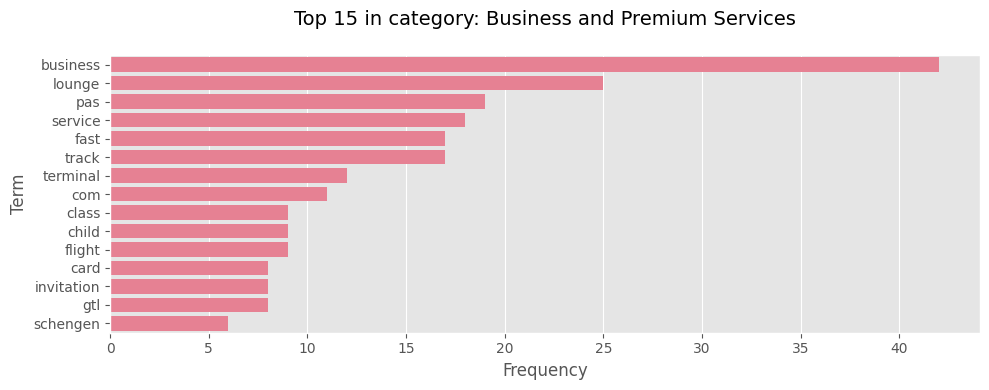


Linguistic statistics:
• Average word length: 6.1 characters
• Unique word ratio: 66.2%
• Empty texts in category: 0

Category: Commercial Services
Number of documents: 4
Sample sentence: contact executive lounge coordinator koordynatorzyexl ppl phone phone executive lounge preludium pho...


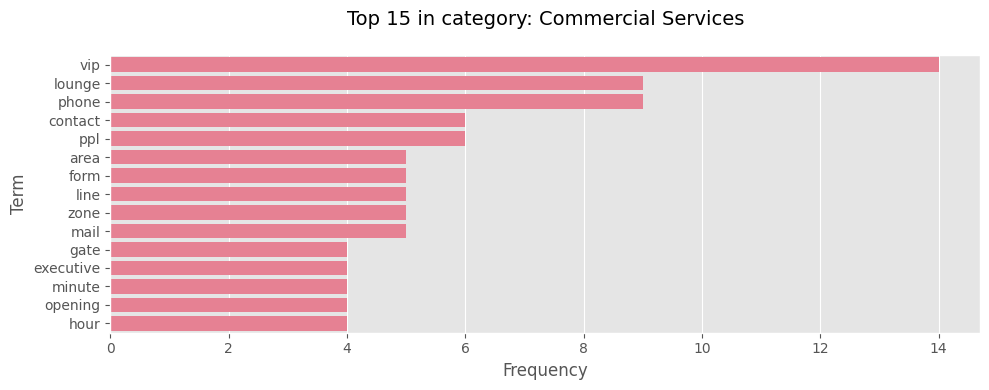


Linguistic statistics:
• Average word length: 5.8 characters
• Unique word ratio: 54.7%
• Empty texts in category: 0

Category: General Information
Number of documents: 28
Sample sentence: obtain temporary passport warsaw chopin airport need document confirming identity valid plane ticket...


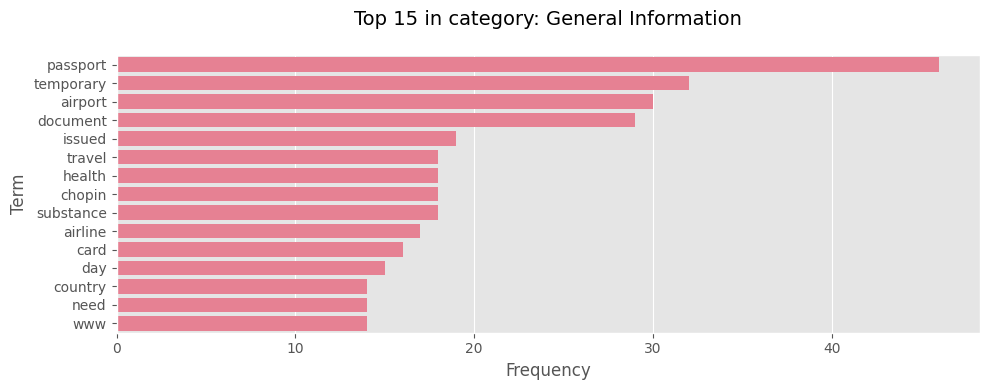


Linguistic statistics:
• Average word length: 6.6 characters
• Unique word ratio: 67.1%
• Empty texts in category: 0

Category: Luggage and Baggage
Number of documents: 12
Sample sentence: cash withdrawal without card euronet arrival departure landside airside customer service center mobi...


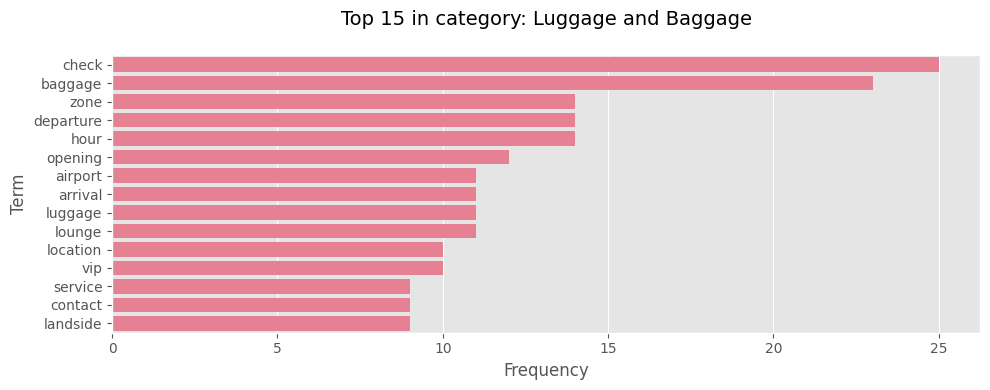


Linguistic statistics:
• Average word length: 6.1 characters
• Unique word ratio: 67.8%
• Empty texts in category: 0

Category: Parking Information
Number of documents: 101
Sample sentence: car park unguarded regular price list ammount time pln...


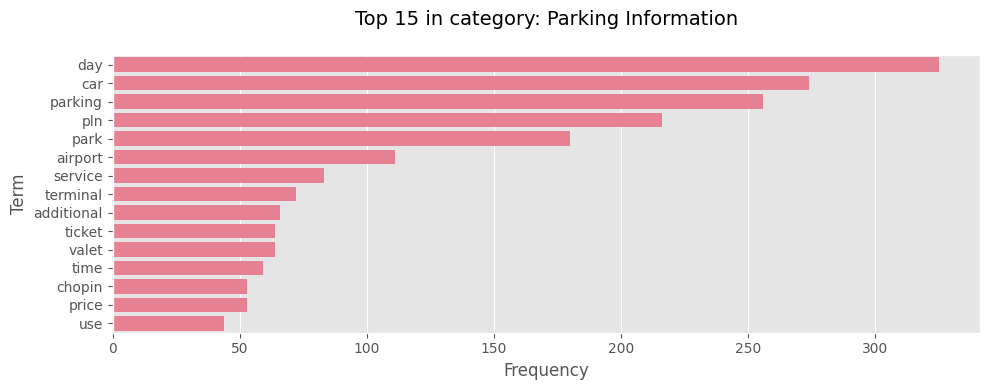


Linguistic statistics:
• Average word length: 5.8 characters
• Unique word ratio: 59.6%
• Empty texts in category: 1

Category: Passenger Assistance and Support
Number of documents: 70
Sample sentence: service fast track fast track service allows pas security screening process quickly conveniently tha...


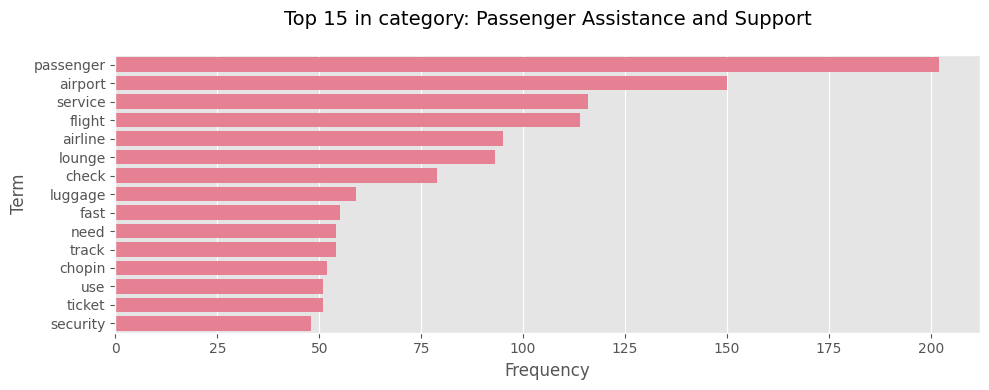


Linguistic statistics:
• Average word length: 6.5 characters
• Unique word ratio: 63.2%
• Empty texts in category: 0

Category: Security and Safety
Number of documents: 9
Sample sentence: baggage rule hand baggage safety reason hand baggage screened security checkpoint check prohibited i...


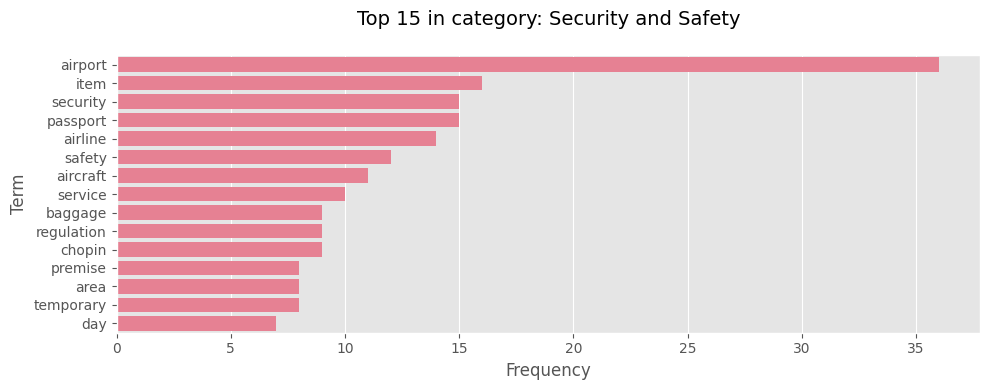


Linguistic statistics:
• Average word length: 6.6 characters
• Unique word ratio: 66.2%
• Empty texts in category: 0

Category: Travel Guidelines
Number of documents: 13
Sample sentence: location departure schengen zone airside center opening hour contact phone mail info aelia virgin vi...


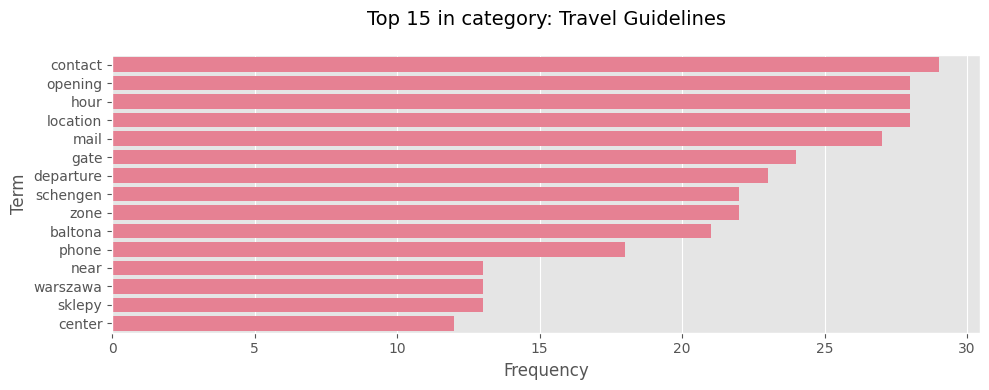


Linguistic statistics:
• Average word length: 6.1 characters
• Unique word ratio: 51.1%
• Empty texts in category: 0


[COMPARATIVE ANALYSIS]

Most distinctive terms per category (TF-IDF):

BUSINESS AND PREMIUM SERVICES:
department, service, fast, track, pas, com, gtl, invitation, lounge, business

COMMERCIAL SERVICES:
schengen, opening, area, gate, minute, ppl, executive, lounge, phone, vip

GENERAL INFORMATION:
code, travel, health, office, ehic, document, airline, www, temporary, passport

LUGGAGE AND BAGGAGE:
arrival, zone, departure, aelia, lounge, luggage, opening, landside, check, baggage

PARKING INFORMATION:
time, valet, ticket, price, additional, park, parking, car, pln, day

PASSENGER ASSISTANCE AND SUPPORT:
fast, business, pas, check, service, airline, flight, lounge, airport, passenger

SECURITY AND SAFETY:
premise, hand, airline, safety, security, passport, baggage, aircraft, airport, item

TRAVEL GUIDELINES:
phone, zone, schengen, hour, contact, gate, baltona, location,

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK tools
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_english(text):
    """Basic English text preprocessing"""
    text = re.sub(r'\d+[:.,]?\d*', ' ', text)  # Remove numbers
    text = re.sub(r'[^\w\s]|_', ' ', text)  # Remove punctuation
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens
              if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

# Apply preprocessing to Text column
merged_df['Text'] = merged_df['Text'].apply(preprocess_english)

# Configure style
plt.style.use('ggplot')
sns.set_palette('husl')
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_category_wordcloud(category_text, category_name, n_words=15):
    """Generate frequency plot for specific category"""
    vec = CountVectorizer(max_features=n_words,
                         token_pattern=r'\b\w+\b',
                         stop_words='english')
    word_counts = vec.fit_transform(category_text).sum(axis=0)
    word_freq = [(word, word_counts[0, idx])
                for word, idx in vec.vocabulary_.items()]
    word_freq.sort(key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=[f[1] for f in word_freq],
                y=[f[0] for f in word_freq])
    plt.title(f'Top {n_words} in category: {category_name}\n', fontsize=14)
    plt.xlabel('Frequency')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

# Group by category and analyze
category_groups = merged_df.groupby('Category')['Text']
print(f"\nLinguistic patterns analysis for {len(category_groups)} categories:")

# Plot for each category
for category_name, group in category_groups:
    print(f"\n{'='*50}\nCategory: {category_name}")
    print(f"Number of documents: {len(group)}")
    print("Sample sentence:", group.sample(1).values[0][:100] + "...")

    # Generate frequency plot
    plot_category_wordcloud(group, category_name)

    # Additional linguistic stats
    total_words = 0
    total_unique = 0
    word_lengths = []

    for text in group:
        words = text.split()
        if len(words) > 0:  # Ignoruj puste teksty
            total_words += len(words)
            total_unique += len(set(words))
            word_lengths.extend([len(w) for w in words])

    # Oblicz statystyki tylko jeśli są dane
    if total_words > 0:
        avg_word_length = np.mean(word_lengths)
        unique_word_ratio = total_unique / total_words
    else:
        avg_word_length = 0.0
        unique_word_ratio = 0.0

    print(f"\nLinguistic statistics:")
    print(f"• Average word length: {avg_word_length:.1f} characters")
    print(f"• Unique word ratio: {unique_word_ratio:.1%}")
    print(f"• Empty texts in category: {len([t for t in group if len(t.strip()) == 0])}")

# Cross-category analysis
print("\n\n[COMPARATIVE ANALYSIS]")
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(merged_df['Text'])

# Get most distinctive words using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(merged_df['Text'])
feature_names = tfidf.get_feature_names_out()

category_terms = defaultdict(list)
for idx, category in enumerate(merged_df['Category'].unique()):
    mask = merged_df['Category'] == category
    avg_tfidf = tfidf_matrix[mask].mean(axis=0)
    top_indices = np.argsort(avg_tfidf.A).flatten()[-10:]
    category_terms[category] = [feature_names[i] for i in top_indices]

print("\nMost distinctive terms per category (TF-IDF):")
for cat, terms in category_terms.items():
    print(f"\n{cat.upper()}:")
    print(", ".join(terms))

### 5) Handle short texts strategy (if Word_Count < 10)

# 2. Model training

### Train test split

In [20]:
from sklearn.model_selection import train_test_split

# Initialize empty DataFrames
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Split for each category separately
for category in merged_df['Category'].unique():
    # Select only records of the current category
    category_data = merged_df[merged_df['Category'] == category]

    # Split into train and test (80/20)
    cat_train, cat_test = train_test_split(
        category_data,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    # Add to main DataFrames
    train_df = pd.concat([train_df, cat_train])
    test_df = pd.concat([test_df, cat_test])

# Shuffle the final datasets
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into features and labels
X_train = train_df['Text']
y_train = train_df['Category']
X_test = test_df['Text']
y_test = test_df['Category']

# Verify the split
print("Category distribution in training set:")
print(train_df['Category'].value_counts(normalize=True))
print("\nCategory distribution in test set:")
print(test_df['Category'].value_counts(normalize=True))
print(f"\nNumber of training samples: {len(train_df)}")
print(f"Number of test samples: {len(test_df)}")
print(f"Train/test ratio: {len(train_df)/(len(train_df)+len(test_df)):.1%}/{len(test_df)/(len(train_df)+len(test_df)):.1%}")

Category distribution in training set:
Category
Parking Information                 0.406091
Passenger Assistance and Support    0.284264
General Information                 0.111675
Business and Premium Services       0.050761
Travel Guidelines                   0.050761
Luggage and Baggage                 0.045685
Security and Safety                 0.035533
Commercial Services                 0.015228
Name: proportion, dtype: float64

Category distribution in test set:
Category
Parking Information                 0.396226
Passenger Assistance and Support    0.264151
General Information                 0.113208
Business and Premium Services       0.056604
Travel Guidelines                   0.056604
Luggage and Baggage                 0.056604
Security and Safety                 0.037736
Commercial Services                 0.018868
Name: proportion, dtype: float64

Number of training samples: 197
Number of test samples: 53
Train/test ratio: 78.8%/21.2%


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import numpy as np

# TF-IDF Vectorizer with optimized parameters
tfidf = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True
)

# Define models optimized for text classification
models = {
    'Random Forest': {
        'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10, 20]
        }
    },
    'K-Neighbors': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {
            'clf__alpha': [0.1, 0.5, 1.0]
        }
    },
    'SVM': {
        'model': SVC(class_weight='balanced', probability=True),
        'params': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf']
        }
    }
}

# Model training and evaluation with hyperparameter tuning
best_score = 0
best_model = None

for name, config in models.items():
    print(f"\n{'='*50}\nTraining {name}...")

    # Create pipeline
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('clf', config['model'])
    ])

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid=config['params'],
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    # Evaluate
    print(f"\nBest parameters for {name}:")
    print(grid_search.best_params_)

    print("\nClassification Report:")
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Track best model
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_

# Save and analyze best model
print(f"\nBest model: {best_model.named_steps['clf'].__class__.__name__}")
print(f"Best F1 score: {best_score:.4f}")

# Feature importance for interpretable models
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    print("\nTop 10 features per class:")
    feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
    importances = best_model.named_steps['clf'].feature_importances_
    top_indices = np.argsort(importances)[-10:]
    print(", ".join(feature_names[top_indices]))


Training Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters for Random Forest:
{'clf__max_depth': 10, 'clf__n_estimators': 200}

Classification Report:
                                  precision    recall  f1-score   support

   Business and Premium Services       0.60      1.00      0.75         3
             Commercial Services       0.00      0.00      0.00         1
             General Information       0.67      1.00      0.80         6
             Luggage and Baggage       1.00      0.33      0.50         3
             Parking Information       1.00      0.81      0.89        21
Passenger Assistance and Support       0.68      0.93      0.79        14
             Security and Safety       0.00      0.00      0.00         2
               Travel Guidelines       1.00      0.67      0.80         3

                        accuracy                           0.79        53
                       macro avg       0.62      0.59      0.5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best parameters for K-Neighbors:
{'clf__n_neighbors': 5, 'clf__weights': 'distance'}

Classification Report:
                                  precision    recall  f1-score   support

   Business and Premium Services       0.67      0.67      0.67         3
             Commercial Services       0.00      0.00      0.00         1
             General Information       0.80      0.67      0.73         6
             Luggage and Baggage       1.00      0.33      0.50         3
             Parking Information       0.94      0.81      0.87        21
Passenger Assistance and Support       0.58      1.00      0.74        14
             Security and Safety       0.00      0.00      0.00         2
               Travel Guidelines       1.00      0.67      0.80         3

                        accuracy                           0.75        53
                       macro avg       0.62      0.52      0.54        53
                    weighted avg       0.77      0.75      0.73        53


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best parameters for Naive Bayes:
{'clf__alpha': 0.1}

Classification Report:
                                  precision    recall  f1-score   support

   Business and Premium Services       0.67      0.67      0.67         3
             Commercial Services       0.00      0.00      0.00         1
             General Information       0.80      0.67      0.73         6
             Luggage and Baggage       1.00      0.33      0.50         3
             Parking Information       0.95      0.86      0.90        21
Passenger Assistance and Support       0.61      1.00      0.76        14
             Security and Safety       0.00      0.00      0.00         2
               Travel Guidelines       1.00      0.67      0.80         3

                        accuracy                           0.77        53
                       macro avg       0.63      0.52      0.54        53
                    weighted avg       0.78      0.77      0.75        53


Training SVM...
Fitting 3 fold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best parameters for SVM:
{'clf__C': 1, 'clf__kernel': 'linear'}

Classification Report:
                                  precision    recall  f1-score   support

   Business and Premium Services       0.67      0.67      0.67         3
             Commercial Services       0.00      0.00      0.00         1
             General Information       0.57      0.67      0.62         6
             Luggage and Baggage       1.00      0.33      0.50         3
             Parking Information       1.00      0.71      0.83        21
Passenger Assistance and Support       0.58      1.00      0.74        14
             Security and Safety       0.00      0.00      0.00         2
               Travel Guidelines       0.67      0.67      0.67         3

                        accuracy                           0.72        53
                       macro avg       0.56      0.51      0.50        53
                    weighted avg       0.75      0.72      0.70        53


Best model: RandomF

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Same preprocessing as for training data
def preprocess_english(text):
    text = re.sub(r'\d+[:.,]?\d*', ' ', text)
    text = re.sub(r'[^\w\s]|_', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens
              if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

def predict_category(sentence, model, show_features=False):
    processed_text = preprocess_english(sentence)

    category = model.predict([processed_text])[0]
    probas = model.predict_proba([processed_text])[0]

    print(f"\nText: '{sentence}'\n")
    print(f"Parsed text: {processed_text}\n")
    print(f"Predicted category: {category}")
    print("\nProbability of category:")
    for cls, prob in zip(model.classes_, probas):
        print(f"• {cls}: {prob:.2%}")

    # Ważne cechy (tylko dla Random Forest)
    if show_features and hasattr(model.named_steps['clf'], 'feature_importances_'):
        feature_names = model.named_steps['tfidf'].get_feature_names_out()
        importances = model.named_steps['clf'].feature_importances_
        print("\nMost important features for category:")
        print(", ".join(feature_names[np.argsort(importances)[-10:]]))

# Przykładowe zdania do testów
test_sentences = [
    "Where can I park my car for 3 days at the airport?",
    "Lost luggage department contact information",
    "Requirements for oversized baggage",
    "How to get VIP lounge access?",
    "Security checkpoint waiting times"
]

# Testowanie każdego zdania
for sentence in test_sentences:
    predict_category(sentence, best_model, show_features=True)
    print("\n" + "="*60 + "\n")


Text: 'Where can I park my car for 3 days at the airport?'

Parsed text: park car day airport

Predicted category: Parking Information

Probability of category:
• Business and Premium Services: 6.54%
• Commercial Services: 0.00%
• General Information: 22.83%
• Luggage and Baggage: 6.53%
• Parking Information: 42.30%
• Passenger Assistance and Support: 14.57%
• Security and Safety: 4.01%
• Travel Guidelines: 3.23%

Most important features for category:
phone mail, contact phone, mail, car, gate, parking, car park, baggage, business, passenger



Text: 'Lost luggage department contact information'

Parsed text: lost luggage department contact information

Predicted category: General Information

Probability of category:
• Business and Premium Services: 12.06%
• Commercial Services: 1.07%
• General Information: 29.57%
• Luggage and Baggage: 9.80%
• Parking Information: 17.20%
• Passenger Assistance and Support: 19.97%
• Security and Safety: 4.43%
• Travel Guidelines: 5.92%

Most importan

# 3.Results

## What can be improved?
Increase the amount of data: Some classes (e.g., “Commercial Services”) have very few examples, making it difficult for models to learn.

Balancing classes: oversampling (e.g., SMOTE) or undersampling can be used.

Better preprocessing: Adding lemmatization, stop word removal, or TF-IDF adjustment.

Testing other models: We can try using XGBoost, LightGBM or neural networks (LSTM).